## Deep set model


This notebook implements the deep set model to predict the yield spreads. The model takes a sequence of trades as input and predicts the spread. The results for all the experiments have been added to a google [sheet](https://docs.google.com/spreadsheets/d/1pm7_xlrlNHcnBVe7mdBYAyTi6mWMMDs0wfR9cejXFaY/edit#gid=0)

In [39]:
import pandas as pd
import numpy as np
from data_preparation import process_data

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

from IPython.display import display, HTML

Initializing big query client

In [3]:
bq_client = bigquery.Client()

### Checking if GPU is available

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Hyper-parameters for the model
The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [149]:
# Training Parameters
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
NUM_EPOCHS = 500


# Model Parameters
SEQUENCE_LENGTH = 5
NUM_FEATURES= 8
DROPOUT_RATE = 0.0
BATCH_SIZE = 1000

# Choose between add, max, and mean
POOLING_METHOD = 'Add'

#### Query to fetch data from BigQuery

The SQL query is a modified version of the [point in time query](https://docs.google.com/document/d/1pUkgovAG_og3oV6G7zF2d9ORq7t-eHJwEXHKKOU6E2k/edit?ts=60942e17). We only use the trades which happened between 01/01/2021 and 04/01/2021 (later date not included). . All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. 


Going forward we will want to remove the query from the notebook and use a view to read the data for the model.


In [43]:
DATA_QUERY = """ SELECT
                    rtrs_control_number,
                    yield_spread,
                    par_traded,
                    trade_type,
                    recent
                 FROM
                     `eng-reactor-287421.primary_views.trade_history_with_reference_data`
                 WHERE
                      trade_date >= '2021-01-01'  AND trade_date < '2021-04-01'
                 AND
                     yield_spread is not NULL
                 LIMIT
                       100000
                """

### Data Preparation

We grab the data from BigQuery and converts it into a format suitable for input to the model. The driver function of this is process_data. All the data processing functions have been moved to the data_preparation.py file. 

The data query returns a table with a nested column, called recent, which contains the  32 recent previous trades in the same CUSIP. The **fetch_data** function executes the query and grabs data from BigQuery as a data frame. 

The aggregated arrays are stored as a list of dictionaries. The **tradeDictToList**  extracts the yield spreads, the size, the type, and seconds elapsed from the dictionary and stores them as a list. In the process of extraction, we perform a few blunt normalizations. The yield spreads are converted from percentage points to basis points. The size of the trade is scaled down by dividing it by 1000. The seconds ago are converted into a logarithmic scale. If the seconds ago are negative (due to trade time after publishing time) the function adds a zero to the list. 

The trades which do not have sufficient history are padded with zeros. The **pad_trade_history** function pads the beginning of trade history with zeros to ensure that the length of the list is equal to trade history. 

| RTRS Control Number | trade_history                                          | yield_spread    |
|:-------------------:|---------------------------------------------------|-----------|
| 2021031700698100    | [[5.997612444822997, 50.0, 0.0, 0.0, 71.458333... | 20.281352 |

In [135]:
%%time
train_dataframe, test_dataframe = process_data(DATA_QUERY,
                                               bq_client,
                                               SEQUENCE_LENGTH,
                                               NUM_FEATURES,
                                               TRAIN_TEST_SPLIT)

Negative seconds ago
Number of training Samples 60566


,rtrs_control_number,yield_spread,par_traded,trade_type,trade_history
1,2021022404041800,83.098138,10000.000000000,D,"[[0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0], [1..."
2,2021010703152400,105.184171,15000.000000000,S,"[[105.18417084254001, 100.0, 0.0, 0.0, 0.06472..."
4,2021022405388900,110.798138,10000.000000000,S,"[[110.798138072993, 10.0, 0.0, 0.0, 0.06994212..."
5,2021012206067000,-70.750303,30000.000000000,S,"[[-70.75030315792901, 5.0, 0.0, 1.0, 0.0715740..."
6,2021030408496500,89.653759,10000.000000000,S,"[[92.553759281004, 25.0, 0.0, 0.0, 0.001527777..."


CPU times: user 37.4 s, sys: 510 ms, total: 37.9 s
Wall time: 1min 24s


In [136]:
# Shuffling the train set
train_dataframe = train_dataframe.sample(frac=1)
display(train_dataframe)

,rtrs_control_number,yield_spread,par_traded,trade_type,trade_history
69541,2021030207707700,1.685606,5000.000000000,S,"[[18.159953482661994, 5.0, 1.0, 0.0, 104.14108..."
57890,2021020200617900,-29.018648,20000.000000000,S,"[[-22.888354703831993, 50.0, 1.0, 0.0, 39.9230..."
69001,2021032402267000,76.010009,30000.000000000,D,"[[109.73661684166902, 10.0, 1.0, 0.0, 146.0758..."
86612,2021031001735700,5.883196,5000.000000000,D,"[[41.359013175934, 10.0, 1.0, 0.0, 141.0727314..."
48228,2021031905861800,-76.964339,30000.000000000,S,"[[-71.66583602828801, 5.0, 0.0, 0.0, 135.07077..."
...,...,...,...,...,...
57249,2021021104830000,-31.178007,100000.000000000,D,"[[-27.865836028288005, 50.0, 0.0, 0.0, 99.0535..."
80258,2021011201484800,11.630269,1665000.000000000,D,"[[19.782018566992, 750.0, 0.0, 0.0, 82.8854398..."
64042,2021010803902200,-25.423433,200000.000000000,S,"[[24.224654543756998, 15.0, 0.0, 0.0, 78.05788..."
53351,2021012105837500,-70.054425,50000.000000000,D,"[[-78.417981433008, 15.0, 1.0, 0.0, 91.9648726..."


Changing the dataframe to numpy array so that data can be fed into the input layer of the model

In [137]:
train_dataframe.trade_history = train_dataframe.trade_history.apply(lambda x: x[-SEQUENCE_LENGTH:])
test_dataframe.trade_history = test_dataframe.trade_history.apply(lambda x:x[-SEQUENCE_LENGTH:])

In [138]:
train_data = np.stack(train_dataframe.trade_history.to_numpy())
target = train_dataframe.yield_spread.to_numpy()

test_data = np.stack(test_dataframe.trade_history.to_numpy())
test_target =  test_dataframe.yield_spread.to_numpy()

In [139]:
print(train_data.shape)
print(target.shape)
print(test_data.shape)

(60566, 5, 8)
(60566,)
(10502, 5, 8)


# DeepSets

DeepSets is a relatively simple way to structure deep neural networks to handle sets instead of ordered lists of elements. This technique enables the neural networks to attain permutation invariance of the inputs. 


Invariance in permutation means that if we present a network with input vector \[A, B, C\]. The network should output the same result as when presented with input \[B,C, A\]


There are three main architectural elements of DeepSets
<ol>
    <li> A neural network to transform the input set. Ideally, it should have many layers. This is called the mapping function.</li>
    <li> A pooling operation, that is used to combine the transformed inputs. In the original paper, they have used addition as the pooling operation. We have used the same</li>
    <li> A feed-forward network to process the pooled features</li>
</ol>

Mathematically DeepSets technique can be written as $\rho(\phi(x)) \ \nabla x \epsilon \chi$. Where $\phi$ is the neural network and $\rho$ is the pooling operation. The implementation of the DeepSets was derived from this GitHub [repository](https://github.com/manzilzaheer/DeepSets).

### Custom layer for average pooling

Since we pad the sequences with zero while pooling we only need to take the average of the non-zero values

In [150]:
class NonZeroMean(layers.Layer):
    def call(self, x): 
        """Calculate non-zero mean."""
        # Count non-zero features
        nonzero = K.any(K.not_equal(x, 0.0), axis=-1)
        n = K.sum(K.cast(nonzero, 'float32'), axis=-1, keepdims=True)
        x_mean = K.sum(x, axis=-2) / n
        return x_mean

    def compute_output_shape(self, input_shape):
        """Collapse summation axis."""
        return input_shape[:-2] + (input_shape[-1],)


### Encoder

The encoder feed forward network is used to transform the elements of the set

In [151]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        self.hidden1 = layers.Dense(32, activation='relu')
        self.hidden2 = layers.Dense(16, activation='relu')
        self.hidden3 = layers.Dense(8, activation='relu')
    def call(self,x):
        return self.hidden3(self.hidden2(self.hidden1(x)))

### Decoder

The decoder network is used to pool the ouputs of the encoder and the use them to predict the yield spreds of the target trade.


In [159]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, POOLING_METHOD):
        super(Decoder, self).__init__()
        self.encoder = Encoder()
        self.POOLING_METHOD = POOLING_METHOD.upper()
        
        if POOLING_METHOD.upper() == "ADD":
            self.pooling_layer = layers.Add()
        elif POOLING_METHOD.upper()  == "MEAN":
            self.pooling_layer = NonZeroMean()
        
        self.hidden1 = layers.Dense(300, activation='relu')
        self.hidden2 = layers.Dense(100, activation='relu') 
        self.hidden3 = layers.Dense(50, activation='relu')
        self.hidden4 = layers.Dense(25, activation='relu')
        self.out = layers.Dense(1)
    
    def call(self, x):
        global count
        count += 1
        encoded_outputs = []
        for trade in range(SEQUENCE_LENGTH):
            temp = x[:,trade,:]
            encoder_output = self.encoder(temp)
            encoded_outputs.append(encoder_output)
        
        if self.POOLING_METHOD == "ADD":
            pooled_representation = self.pooling_layer(encoded_outputs)
            
        elif self.POOLING_METHOD == "MEAN":
            encoded_outputs = tf.stack(encoded_outputs)
            encoded_outputs = tf.reshape(encoded_outputs, [-1,SEQUENCE_LENGTH,8])
            pooled_representation = NonZeroMean()(encoded_outputs)
    
        elif self.POOLING_METHOD == "MAX":
            encoded_outputs = tf.stack(encoded_outputs)
            encoded_outputs = tf.reshape(encoded_outputs, [-1,SEQUENCE_LENGTH,8])
            pooled_representation = tf.reduce_max(encoded_outputs,axis=1)

        #K.print_tensor(pooled_representation)
        
        del encoded_outputs
        
        output = self.hidden1(pooled_representation)
        output = self.hidden2(output)
        output = self.hidden3(output)
        
        return self.out(output)
        

### Training the model
This is the driver function that trains the deep set model.

In [160]:
class DeepSetModel(tf.keras.Model):
    def __init__(self, POOLING_METHOD):
        super(DeepSetModel, self).__init__()
        self.decoder = Decoder(POOLING_METHOD)
        
    def call(self, x):
        output = self.decoder(x)  # (batch_size, set_len, d_model)
        return output

In [161]:
model = DeepSetModel(POOLING_METHOD)

In [162]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [163]:
%%time
history = model.fit(train_data, target, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,  verbose=2, validation_split=0.2)

Epoch 1/500
49/49 - 1s - loss: 24683.8984 - mean_absolute_error: 51.4878 - val_loss: 19690.4746 - val_mean_absolute_error: 39.5251
Epoch 2/500
49/49 - 0s - loss: 18385.3789 - mean_absolute_error: 37.4873 - val_loss: 18571.4238 - val_mean_absolute_error: 35.8314
Epoch 3/500
49/49 - 0s - loss: 18156.0273 - mean_absolute_error: 36.5317 - val_loss: 19383.7305 - val_mean_absolute_error: 35.6407
Epoch 4/500
49/49 - 0s - loss: 17906.8887 - mean_absolute_error: 35.8751 - val_loss: 19160.9609 - val_mean_absolute_error: 34.0123
Epoch 5/500
49/49 - 0s - loss: 17902.4258 - mean_absolute_error: 35.4573 - val_loss: 18973.1426 - val_mean_absolute_error: 34.8528
Epoch 6/500
49/49 - 0s - loss: 17513.0684 - mean_absolute_error: 35.3106 - val_loss: 18753.5195 - val_mean_absolute_error: 33.9479
Epoch 7/500
49/49 - 0s - loss: 17587.2422 - mean_absolute_error: 34.6084 - val_loss: 18853.0684 - val_mean_absolute_error: 34.6691
Epoch 8/500
49/49 - 0s - loss: 17909.7031 - mean_absolute_error: 34.8569 - val_loss

In [164]:
_, mae = model.evaluate(test_data, test_target, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

329/329 [==============================] - 1s 2ms/step - loss: 6422.0977 - mean_absolute_error: 27.4536
Test MAE: 27.454


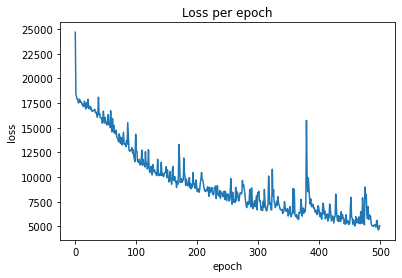

In [165]:
plt.plot(range(len(history.history['loss'])),history.history['loss'])
plt.title('Loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()